# Урок 8. Снижение размерности данных 

Большая размерность данных (под ней понимается размерность пространства признаков, то есть их количество) может серьезно усложнить задачу анализа таких данных и даже стать причиной некорректной работы некоторых алгоритмов. Кроме того, часто в исходных данных могут присутствовать лишние признаки, никак не связанные с целевой переменной. Поэтому часто встает задача понижения количества признаков, оставляя при этом самые значимые (наиболее сильно влияющие на значение целевого параметра) с отсечением менее значимых (наиболее слабо коррелирующих со значением целевого параметра) или с формированием новых признаков на основе старых. То есть ставится задача перехода от пространства большей размерности к пространству меньшей размерности с сохранением максимального количества полезной информации.

## Алгоритмы снижения размерности

Алгоритмы снижения размерности пространства признаков делятся на две группы - отбор признаков (то есть отбрасывание наименее важных признаков) и понижение размерности путем формирования новых признаков на основе старых.

### Отбор признаков

Самым простым и примитивным методом отбора является _одномерный отбор признаков_. Он заключается в оценке предсказательной силы каждого признака, то есть его информативности - насколько он коррелирует с целевой переменной. Затем отбираются либо заданное количество $k$ признаков, либо те признаки, информативность которых выше некоторого порога.

Оценка предсказательной силы признака (или степени связи этого признака и целевой переменной) может проводиться разными методами, например:

- в случае регрессии - _корреляция_ $$R_{j} = \frac{\sum_{i=1}^{l}(x_{ij} - \bar{x}_{j})(y_{i} - \bar{y})}{\sqrt{\sum_{i=1}^{l}(x_{ij} - \bar{x}_{j})^{2}\sum_{i=1}^{l}(y_{i} - \bar{y})^{2}}},$$ где $\bar{x_{j}}$ и $\bar{y}$ - среднее значение $j$-го признака и целевой переменной, соответственно. Чем больше по модулю корреляция ($\pm 1$), тем информативнее признак. Следует заметить, что этот метод учитывает только линейную связь между признаком и целевой переменной.


In [36]:
import numpy as np

x = np.linspace(-3, 3, 100)
y = x ** 2
np.corrcoef(x, y)[0,1]

2.0032400227841138e-16

In [38]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
x = np.linspace(-3, 3, 100)
y = x ** 2 + np.random.randn(100) * 100
model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))
np.corrcoef(y_pred, y)[0,1]

0.6241078875536952

- в случае задачи классификации - _взаимная информация (mutual information)_, моделирующая корреляцию между признаками и классами. Она использует в расчете вероятность того, что одновременно значение $j$-го признака $x_{ij}$ равно числу $v$ и значение целевой переменной $y_{i}=k$, или, другими словами, долю таких объектов от общего количества объектов в выборке $P(x=v,y=k)$. Тогда взаимная информация будет находиться как $$MI_{j}=\sum_{v \in X}\sum_{k \in Y}P(x=v,y=k)\text{log}\frac{P(x=v,y=k)}{P(x=v)P(y=k)}.$$ Здесь $P(x=v)$ и $P(y=k)$ - доли объектов, на которых значение признака равно $v$ и значение целевой переменной равно $k$, соответственно. Если признак и целевая переменная независимы, то взаимная информация обращается в ноль. В отличие от предыдущего метода, этот метод позволяет находять произвольные зависимости (в т.ч. нелинейные) в пространстве произвольной размерности.

Такие методы позволяют оценить важность исключительно каждого признака отдельно, без учета влияния комбинаций признаков на целевую переменную, поэтому они и называются одномерными. На практике зачастую признаки влияют именно в совокупности, и по отдельности могут ошибочно быть расценены как некоррелирующие с целевой переменной, поэтому одномерные методы отбора не являются оптимальным методом в большинстве случаев.

Отдельной группой методов можно назвать так называемые _переборные методы_, которые дискретно оценивают качество модели, обученной на различных подмножествах признаков. При этом происходит полный перебор всех возможных вариантов. Обычно такие алгоритмы делятся на _жадные (greedy)_ и _нежадные (non-greedy)_. Полный список их можно найти в дополнительных материалах.

In [ ]:
# жадное исключение
1 2 3 
1 2
2 3 +
1 3
2
3

In [ ]:
# жадное включение
1
2 +
3
2 1
2 3
#1 2 3

Жадность алгоритмов заключаются в том, что если один из признаков включен в подмножество (или исключен в случае исключающего метода), в следующих итерациях поиска он уже не учитывается, так что алгоритм работает на меньшем объеме данных. Известные алгоритмы этого типа - _жадное включение_ и _жадное исключение_. В случае жадного включения на первой итерации аналогично одномерному отбору признаков находится признак, обладающий наибольшей предсказательной силой и добавляется в формирующуееся подмножество $\{i_{1}\}$. Далее происходит перебор оставшихся признаков с попеременным добавлением каждого из них в подмножество к первому и оценкой качества получаемой модели, обученной на подмножестве из этих двух признаков $\{i_{1}, i_{2}\}$. В итоге в подмножестве остается тот признак, при добавлении которого получается наилучшее качество. Далее эта процедура повторяется до момента, пока ошибка получаемой модели уменьшается. На каждой итерации в подмножество добавляется один признак, максимально улучшающий работу модели. Если на какой-то итерации при добавлении признаков ошибка не уменьшается, процесс останавливается.

Плюсом такого алгоритма является относительная быстрота и возможность учета некоторых взаимодействий между признаками (как раз то, чего лишен одномерный отбор). Минусом же можно назвать вероятность застрять в локальном минимуме ошибки, если такой есть. В случае же когда есть единственный глобальный минимум, алгоритм найдет оптимальное решение.

Есть также модификации этого алгоритма с многократным проходом по выборке и поочередным включением/исключением признаков из подмножества для учета совокупного влияния признаков.

Примером нежадного алгоритма может быть простой последовательный полный перебор всех возможных подмножеств признаков. Такой подбор позволяет найти наиболее оптимальное подмножество признаков, но, очевидно, он является достаточно трудоемким (нужно перебрать $2^{n}$ вариантов, где $n$ - число признаков), поэтому подходит только для датасетов с небольшим количеством признаков.

In [ ]:
# Permutation feature importance
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
base_score = score(y_valid, y_pred)

for feature in X_valid.columns:
    X_valid_ = X_valid.copy()
    X_valid_[feature] = np.random.permutation(X_valid_[feature])
    y_pred = model.predict(X_valid_)
    score_ = score(y_valid, y_pred)
    score_ < base_score # признак сильный

Еще одна группа методов отбора признаков - _встроенные в модели_. Они используют эвристики, заложенные в обучающие модели, для оценки важности признаков.

- Например, в случае работы с линейными моделями мы имеем зависимость целевой переменной от взвешенной суммы признаков $$a(x) = \sum_{i=1}^{n}w_{i}x^{i}.$$ Здесь, если признаки масштабированы, веса будут являться показателями информативности признаков: чем больше вес, тем больший вклад данный признак вносит в значение целевой переменной. На основе этого показателя можно проводить отбор признаков. Также, вспоминая уроки по линейным моделям, можно упомянуть, что использование $L_{1}$-регуляризации приводит к занулению весов наименее важных признаков, то есть к их отбрасыванию, при этом больший коэффициент регуляризации будет приводить к большему количеству зануленных весов.

- В случае использования решающих деревьев и их композиций, где в каждой вершине происходит разбиение на два поддерева путем сравнивания значения одного признака с некоторым значением порога, важность признака можно оценивать по тому, насколько он уменьшает значение критерия информативности, по которому оценивается качество разбиения: $$Q(X_{m}, j, t) = H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$ где $X_{m}$ - множество объектов, попавших в вершину на данном шаге, $X_{l}$ и $X_{r}$ - множества, попадающие в левое и правое поддерево, соответственно, после разбиения. $H(X)$ - критерий информативности. 
    
    Чем сильнее падает критерий информативности при разбиении по данному признаку (то есть чем выше $Q$), тем этот признак важнее. Таким образом, важность $j$-го признака можно оценить путем вычисления суммы уменьшений критерия информативности по всем вершинам, в которых делалось разбиение по данному признаку. Чем больше эта сумма, тем важнее данный признак был при построении дерева. В случае композиций деревьев этот показатель суммируется по всем деревьям.

### Понижение размерности

Кроме отбора признаков, который не всегда оптимален в плане сохранения максимума полезной информации, существуют еще методы понижения размерности путем формирования новых признаков на основе старых. Новых признаков при использовании такого метода должно быть меньше, чем исходных, при условии сохранения максимально возможного количества информации из исходных признаков. Например, объединение нескольких признаков в линейную комбинацию:

$$z_{ij}=\sum_{k=1}^{n}w_{jk}x_{ik},$$

где $x_{ij}$ - исходные признаки, $z_{ij}$ - новые принаки.

Простейшим методов такого понижения размерности является метод _случайных проекций_, который заключается в преобразованиях, сохраняющих расстояния и снижающих размерности. Существование таких преобразований доказано для выборок, в которых объектов меньше, чем признаков. Веса при всех признаках в таком методе можно выбирать случайно. При этом не факт, что мы попадем в оптимальное преобразование, но практика показывает, что метод работает, если размерность нового пространства признаков

$$d > \frac{8\text{ln}l}{\varepsilon^{2}},$$

где $l$ - количество объектов, $\varepsilon$ - максимальное изменение расстояния между объектами (лемма о малом искажении или лемма Джонсона-Линденштрауса).

#### Метод главных компонент (PCA)

Одним из наиболее известных и широко применяемых методов понижения размерности является _метод главных компонент (principal component analysis, PCA)_. Он заключается в приближении матрицы признаков матрицей меньшего ранга - так называемом низкоранговом приближении.

Запишем показанную ранее формулу линейного преобразования признаков в матричном виде:

$$Z = XW^{T},$$

где $X$ - матрица "объекты-признаки", где по строкам отложены объекты, а по столбцам - значения признаков, $Z$ - матрица новых признаков, $W^{T}$ - транспонированная матрица весов. Приближение заключается формировании новой матрицы признаков $\tilde{X}=ZW\approx X$ с возможностью восстанавливания старых признаков по новым с максимальным уровнем точности, или, если говорить иначе, чтобы их различие было минимальным:

$$\|ZW - X\|^{2} \rightarrow \underset{Z, W}{\text{min}}.$$

При этом метод главных компонент предполагает, что матрица весов должна быть ортогональной, то есть произведение $WW^{T}$ должно равняться единичной матрице. Восстановленная матрица $ZW$ может иметь ранг меньший, чем исходная $X$, поэтому приближение будет называться низкоранговым.

Геометрически метод можно представить как проецирование признаков на гиперплоскость с максимизацией дисперсии получаемой выборки.

Если ранг матрицы исходных признаков $rank(X) \geq d$, где $d$ - число новых признаков, то минимум функционала различия, описанного выше, достигается тогда, когда в качестве строк матрицы $W$ используются собственные векторы матрицы $X^{T}X$ , соответствующие максимальным собственным значениям $\lambda_{1},...,\lambda_{d}$. Максимальные собственные значения и называются главными компонентами, от чего пошло название метода. Первая главная компонента соответствует максимальному собственному значению и т.д.

Некоторые полезные свойства метода:

- Матрица $Z$ при этом будет такой, что $Z^{T}Z = \Lambda = diag(\lambda_{1},...,\lambda_{d})$.


- Минимизированный функционал ошибки будет равен $$\|ZW - X\|^{2} = \|X\|^{2} - tr\Lambda,$$ где $tr\Lambda,$ - след матрицы $\Lambda$, то есть сумма всех собственных значений $\lambda_{1},...,\lambda_{d}$, а $\|X\|^{2}$ - сумма всех собственных значений исходной матрицы $\lambda_{1},...,\lambda_{n}$, таким образом $$\|ZW - X\|^{2} = \sum_{j=d+1}^{n}\lambda_{j},$$ то есть значение функционала ошибки будет равно сумме собственных значений, которые не были взяты в получаемое разложение. Поэтому логично брать в разложение максимальные собственные значения, оставляя минимальные.


- Матрица $X^{T}X$ - матрица ковариации, то есть матрица, которая характеризует дисперсию выборки. Дисперсия выборки после проецирования будет равна собственному значению $\lambda$, поэтому логично, что первым берется собственный вектор, соответствующий максимальному собственному значению - нам нужно сохранить максимум дисперсии.

Таким образом, для реализации метода главных компонент нужно :
- найти собственные значения матрицы $X^{T}X$;
- отобрать $d$ максимальных;
- составить матрицу $W^{T}$, столбцы которой будут являться собственными векторами, соответствующими отобранным собственным значениям, расположенным в порядке убывания;
- получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

In [ ]:
A * v = k * v

#### PCA и SVD

Сформулировав принцип реализации метода главных компонент, нельзя не заметить его родство с сингулярным разложением матриц (SVD). Вспомним, что сингулярное разложение матрицы - это разложение вида

$$X=UDV^{T},$$

где столбцы ортогональной матрицы $U$ - это собственные векторы матрицы $XX^{T}$, столбцы ортогональной матрицы $V$ - собственные векторы матрицы $X^{T}X$, а на главной диагонали диагональной матрицы $D$ расположены собственные значения матриц $XX^{T}$ и $X^{T}X$ (они равны и также называются сингулярными числами матрицы $X$).

Если число новых признаков $d$ равно старому числу признаков $n$, то можно приравнять разложения

$$X=ZW=UDV^{T}.$$

При этом матрицы $W$ и $V^{T}$ состоят из собственных векторов матрицы $X^{T}X$, то есть они равны при $Z=UD$.

Получается, что метод опорных векторов - в своем роде "урезанная версия" сингулярного разложения, из которого убрали минимальные собственные значения с соответствующими собственными векторами. 
Таким образом, для реализации понижения размерности методом опорных векторов с помощью SVD нужно:
- найти сингулярное разложение вектора $X$;
- сформировать из столбцов матрицы $V$, соответствующих $d$ наибольшим сингулярным числам, матрицу весов $W$;
- получить новую матрицу "объекты-признаки", умножив исходную матрицу $X$ на матрицу весов $W$:

$$Z=XW.$$

Для закрепления теории реализуем PCA с помощью Python.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

In [3]:
# Для начала отмасштабируем выборку
X_ = X.astype(float)

rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по признаку
means = X_.mean(axis=0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for j in range(cols):
    for i in range(rows):
        X_[i, j] /= std[j]

In [ ]:
(4, 150) * (150, 4) = (4, 4)

In [6]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X_.T.dot(X_)

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения в порядке убывания:')
for i in eig_pairs:
    print(i[0])

Собственные значения в порядке убывания:
437.77467247979905
137.1045707202104
22.01353133569722
3.1072254642928634


Оценим долю дисперсии, которая описывается найденными компонентами.

In [7]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описвыаемая каждой из компонент \n{var_exp}')

# а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описвыаемая каждой из компонент 
[72.96244541329992, 22.850761786701757, 3.6689218892828737, 0.5178709107154778]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Таким образом, первая главная компонента описывает почти 73% информации, а первые две в сумме - 95.8%. В то же время последняя компонента описывает всего 0.5% и может быть отброжена без страха значительных потерь в качестве нашего анализа. Мы отбросим последние две компоненты, оставив первые две.

In [8]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [ ]:
(150, 4) * (4, 2) = (150, 2)

In [10]:
# Сформируем новую матрицу "объекты-признаки"
Z = X_.dot(W)
Z.shape

(150, 2)

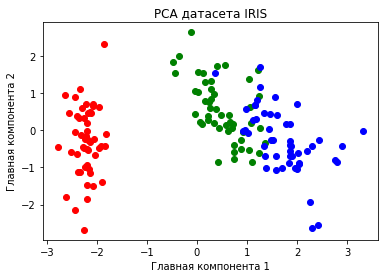

In [11]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

Таким образом, мы перешли от четырехмерного пространства признаков к двумерному и при этом классы остались разделимы в пространстве, то есть классификация возможна.

PCA наиболее хорошо работает, когда собственные значения $\lambda$ на каком-то участке графика распределения убывают скачкообразно (критерий крутого склона), другими словами, если существуют предпосылки к тому, что следует решать задачу в пространстве меньшей размерности. Если же они убывают монотонно, следует рассмотреть вариант использования других методов работы с пространством признаков.

## Дополнительные материалы

1. [Методы отбора признаков](https://habr.com/ru/company/aligntechnology/blog/303750/)
2. [Взаимная информация](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%B0%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F)
3. [Методы понижения размерности](http://www.machinelearning.ru/wiki/images/0/06/SLT%2C_lecture_8.pdf)
4. [Лемма о малом искажении](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BC%D0%BC%D0%B0_%D0%BE_%D0%BC%D0%B0%D0%BB%D0%BE%D0%BC_%D0%B8%D1%81%D0%BA%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8)
5. [PCA from Scratch in Python](https://github.com/bhattbhavesh91/pca-from-scratch-iris-dataset)

Хороший разбор работы PCA. На пальцах и с подробными примерами: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

## Домашнее задание

1. Можно ли отобрать наиболее значимые признаки с помощью PCA?
2. (\*) Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)
3. (\*) Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.
4. (\*) Принять участие в одном или двух соревнованиях и прислать свой псевдоним на Kaggle и ссылку на github с решением задачи:
    - по регрессии https://www.kaggle.com/c/tutors-expected-math-exam-results
    - или классификации https://www.kaggle.com/c/choose-tutors 
    
    В скрипте можно использовать только эти импорты:


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor # только для бустинга
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

## Task №1

По матрице Z невозможно однозначно сказать, какие признаки являются более значимыми. PCA "сжимает" данные, и без матрицы весов не получится сказать о важности признаков.

In [12]:
Z

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356],
       [-2.1663101 , -1.04369065],
       [-2.32613087, -0.13307834],
       [-2.2184509 ,  0.72867617],
       [-2.6331007 ,  0.96150673],
       [-2.1987406 , -1.86005711],
       [-2.26221453, -2.68628449],
       [-2.2075877 , -1.48360936],
       [-2.19034951, -0.48883832],
       [-1.898572  , -1.40501879],
       [-2.34336905, -1.12784938],
       [-1.914323  , -0.40885571],
       [-2.20701284, -0.92412143],
       [-2.7743447 , -0.45834367],
       [-1.81866953, -0.08555853],
       [-2.22716331, -0.13725446],
       [-1.95184633,  0.62561859],
       [-2.05115137, -0.24216355],
       [-2.16857717, -0.52714953],
       [-2.13956345,

In [15]:
W.T

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [-0.37741762, -0.92329566, -0.02449161, -0.06694199]])

In [14]:
X

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3